In [1]:

import torch
import os
import random
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Set the seed for reproducibility
SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)  # Apply the seed


In [2]:

BATCH_SIZE = 32
EPOCHS = 100
INPUT_SIZE = (256, 256)  

def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

main_data_dir = r"C:\Users\Josh\Desktop\CUDA\skindiseases"
train_dir = os.path.join(main_data_dir, "train")
val_dir = os.path.join(main_data_dir, "val")
test_dir = os.path.join(main_data_dir, "test")

train_files = count_files_in_directory(train_dir)
val_files = count_files_in_directory(val_dir)
test_files = count_files_in_directory(test_dir)

print(f"Training Dataset: {train_files}")
print(f"Validation Dataset: {val_files}")
print(f"Test Dataset: {test_files}")

Training Dataset: 2800
Validation Dataset: 800
Test Dataset: 400


In [3]:

# Load the training dataset to calculate mean and std, and get class labels
train_dataset = datasets.ImageFolder(root=train_dir)
class_n = list(train_dataset.class_to_idx.keys())  # Automatically retrieves class names from folders
print("Class to label mapping:", train_dataset.class_to_idx)

Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Normal': 2, 'Perioral Dermatitis': 3, 'Psoriasis': 4, 'Rosacea': 5, 'Seborrheic Dermatitis': 6, 'Tinea Faciei': 7}


In [4]:
# # Function to calculate mean and std for the dataset
# def calculate_mean_std(loader):
#     mean = 0.0
#     std = 0.0
#     total_images_count = 0
#     for images, _ in loader:
#         batch_samples = images.size(0)  # batch size (the last batch can have smaller size!)
#         images = images.view(batch_samples, images.size(1), -1)  # reshape to (batch_size, channels, height * width)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += batch_samples

#     mean /= total_images_count
#     std /= total_images_count
#     return mean, std

# # Temporary transform to load the dataset without normalization for mean and std calculation
# transform_temp = transforms.Compose([
#     transforms.Resize(INPUT_SIZE),
#     transforms.CenterCrop((227, 227)),
#     transforms.ToTensor()
# ])

# # Load the training dataset without normalization
# train_dataset_temp = datasets.ImageFolder(root=train_dir, transform=transform_temp)
# train_loader_temp = DataLoader(train_dataset_temp, batch_size=BATCH_SIZE, shuffle=False)

# # Calculate mean and std
# mean, std = calculate_mean_std(train_loader_temp)
# print(f"Calculated Mean: {mean}")
# print(f"Calculated Std: {std}")

In [5]:
import cv2

class KMeansSegmentation:
    def __init__(self, n_clusters=8, overlay_alpha=0.5):
        self.n_clusters = n_clusters
        self.overlay_alpha = overlay_alpha

    def __call__(self, img):
        # Convert PIL image to NumPy array
        img_np = np.array(img)

        # Reshape the image to a 2D array of pixels
        pixel_values = img_np.reshape((-1, 3))
        pixel_values = np.float32(pixel_values)

        # Define criteria and apply K-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(pixel_values, self.n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert centers back to 8-bit values and reshape labels to the original image shape
        centers = np.uint8(centers)
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(img_np.shape)

        # Convert segmented image to grayscale to create a mask
        gray_segmented = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray_segmented, 1, 255, cv2.THRESH_BINARY)

        # Blend the segmented regions back onto the original image
        img_segmented = cv2.addWeighted(img_np, 1 - self.overlay_alpha, segmented_image, self.overlay_alpha, 0)

        # Convert back to PIL Image
        return Image.fromarray(img_segmented)


In [6]:

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Apply CLAHE on each channel independently if it's a color image
        if len(img_np.shape) == 3:
            channels = cv2.split(img_np)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            channels = [clahe.apply(channel) for channel in channels]
            img_np = cv2.merge(channels)
        else:
            # Apply CLAHE on grayscale images
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)

        # Convert back to PIL Image
        img_clahe = Image.fromarray(img_np)
        return img_clahe


In [7]:
import numpy as np
from torchvision import transforms
from PIL import Image

MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)


# Define transformations
transform_train = transforms.Compose([
    # Resize to standardize input dimensions
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)), 

    # Apply CLAHE
    transforms.RandomApply([CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))], p=0.5),

     # Apply KMeans segmentation
    transforms.RandomApply([KMeansSegmentation(n_clusters=3, overlay_alpha=0.5)], p=0.3),

    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 20))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0, 10))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-20, 0))], p=0.25),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-10, 0))], p=0.25),

    # Subtle affine transformations and other adjustments
    transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), shear=2)], p=0.3),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.05, p=0.2)], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.4),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.7),
    transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=1.5)], p=0.3),

    # Convert to tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation and test transformations
transform_val_test = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Load the datasets with the new transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_val_test)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
images, labels = next(iter(train_loader))
print(images.shape)  

torch.Size([32, 3, 227, 227])


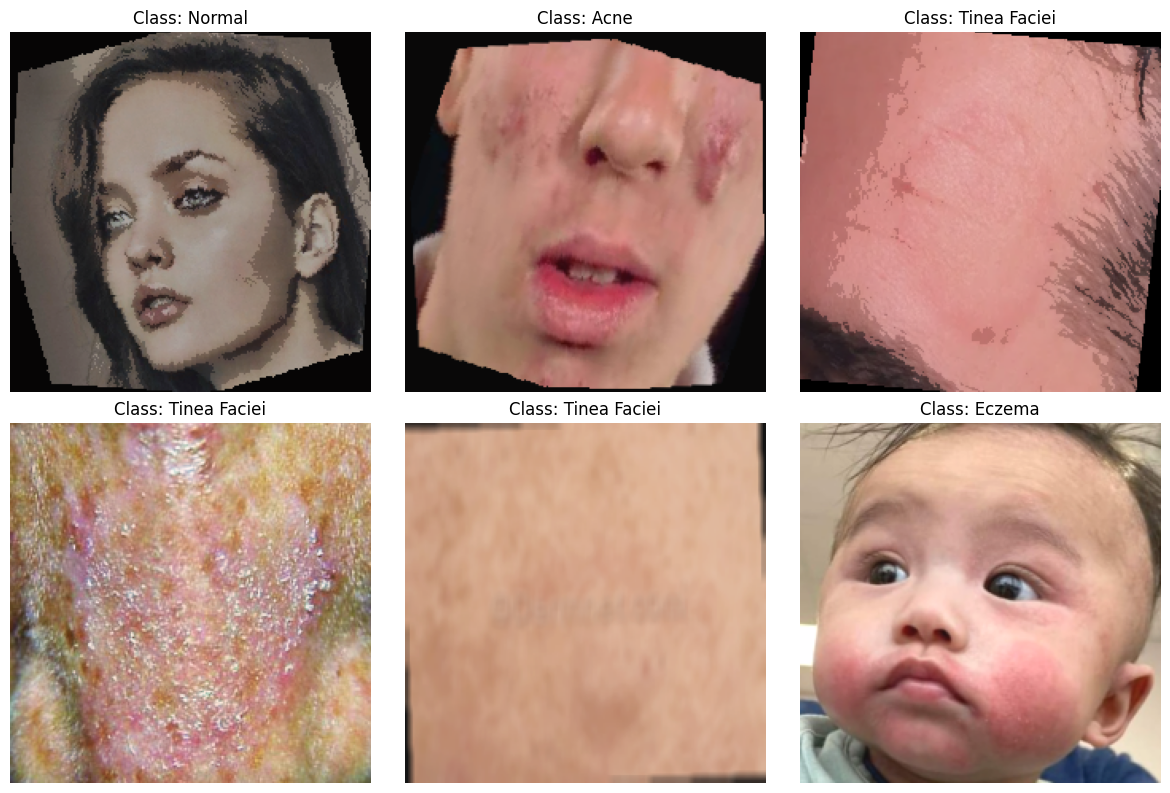

In [9]:

# Function to unnormalize the image for visualization
def unnormalize(image, mean, std):
    # Convert the tensor to a NumPy array and transpose dimensions to (H, W, C)
    image = image.numpy().transpose((1, 2, 0))  
    
    # Unnormalize by reversing the mean and std normalization
    image = (image * std) + mean  
    
    # Clip values to be between 0 and 1 for valid image display
    image = np.clip(image, 0, 1)  
    return image


# Visualize a batch of images from the train_loader
def visualize_loader(loader, mean, std, class_names, num_images=6):
    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)  

    # Plot the images
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        image = unnormalize(images[i], mean, std)  
        plt.imshow(image)
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use this function to visualize a batch of images
visualize_loader(train_loader, mean=MEAN, std=STD, class_names=class_n)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary

# Instantiate the model
num_classes = 8

# Define a modified AlexNet model with the original classifier structure but a new output layer
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=8):  # Set num_classes to 8
        super(ModifiedAlexNet, self).__init__()
        
        # Load AlexNet with pretrained weights
        self.model = models.alexnet(pretrained=True)
        
        # Modify only the final layer of the classifier to match the number of output classes
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # Change to 8 classes

    def forward(self, x):
        return self.model(x)


# Instantiate and move the model to GPU if available
alexnet = ModifiedAlexNet(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# Define the loss function and optimizer to fine-tune all layers
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=1e-5, weight_decay=1e-4)  # Include all model parameters

# Display the model summary
summary(alexnet, input_size=(3, 227, 227))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [13]:
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

PATIENCE = 10

# Define the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE)

# Implement early stopping
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, scheduler, patience, save_path='best_model.pth'):
    train_losses = []  
    val_losses = []   
    train_accuracies = []  
    val_accuracies = []    

    best_val_accuracy = 0.0  
    best_epoch = 0  
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Zero gradients
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                running_loss += loss.item()  # Accumulate loss

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=100 * correct / total)

        epoch_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total 
        train_losses.append(epoch_train_loss)  
        train_accuracies.append(train_accuracy)  

        # Validation loop
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            with tqdm(val_loader, unit="batch", leave=False) as vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{epochs}")
                for inputs, labels in vepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    vepoch.set_postfix(val_loss=val_loss / (vepoch.n + 1), val_accuracy=100 * correct / total)

        epoch_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total 
        val_losses.append(epoch_val_loss) 
        val_accuracies.append(val_accuracy)  

        print(f'\nEpoch [{epoch+1}/{epochs}] - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        scheduler.step(epoch_val_loss)

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            patience_counter = 0
            print(f"New best validation accuracy: {val_accuracy:.2f}% at epoch {best_epoch}. Saving model...\n")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"\nTraining complete. Best validation accuracy: {best_val_accuracy:.2f}% at epoch {best_epoch}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    alexnet, train_loader, val_loader, 
    EPOCHS, criterion, optimizer, 
    device, scheduler, patience=PATIENCE, 
    save_path='alexnet_best_model.pth')


Epoch 1/100: 100%|██████████| 88/88 [01:20<00:00,  1.09batch/s, accuracy=27.7, loss=1.92]



Epoch [1/100] - Train Loss: 1.9179, Train Accuracy: 27.68%, Validation Loss: 1.7328, Validation Accuracy: 36.38%
New best validation accuracy: 36.38% at epoch 1. Saving model...



Epoch 2/100: 100%|██████████| 88/88 [01:23<00:00,  1.05batch/s, accuracy=37.9, loss=1.62]



Epoch [2/100] - Train Loss: 1.6246, Train Accuracy: 37.86%, Validation Loss: 1.6013, Validation Accuracy: 43.38%
New best validation accuracy: 43.38% at epoch 2. Saving model...



Epoch 3/100: 100%|██████████| 88/88 [01:25<00:00,  1.03batch/s, accuracy=42.9, loss=1.5] 



Epoch [3/100] - Train Loss: 1.5049, Train Accuracy: 42.86%, Validation Loss: 1.5132, Validation Accuracy: 45.88%
New best validation accuracy: 45.88% at epoch 3. Saving model...



Epoch 4/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=47.1, loss=1.4] 



Epoch [4/100] - Train Loss: 1.3983, Train Accuracy: 47.07%, Validation Loss: 1.4427, Validation Accuracy: 49.50%
New best validation accuracy: 49.50% at epoch 4. Saving model...



Epoch 5/100: 100%|██████████| 88/88 [01:25<00:00,  1.03batch/s, accuracy=50.6, loss=1.34]



Epoch [5/100] - Train Loss: 1.3435, Train Accuracy: 50.57%, Validation Loss: 1.4186, Validation Accuracy: 50.25%
New best validation accuracy: 50.25% at epoch 5. Saving model...



Epoch 6/100: 100%|██████████| 88/88 [01:26<00:00,  1.01batch/s, accuracy=52, loss=1.3]   



Epoch [6/100] - Train Loss: 1.2953, Train Accuracy: 51.96%, Validation Loss: 1.4004, Validation Accuracy: 50.50%
New best validation accuracy: 50.50% at epoch 6. Saving model...



Epoch 7/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=54.3, loss=1.26]



Epoch [7/100] - Train Loss: 1.2594, Train Accuracy: 54.29%, Validation Loss: 1.3756, Validation Accuracy: 52.50%
New best validation accuracy: 52.50% at epoch 7. Saving model...



Epoch 8/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=55.8, loss=1.23]



Epoch [8/100] - Train Loss: 1.2265, Train Accuracy: 55.75%, Validation Loss: 1.3328, Validation Accuracy: 53.25%
New best validation accuracy: 53.25% at epoch 8. Saving model...



Epoch 9/100: 100%|██████████| 88/88 [01:25<00:00,  1.02batch/s, accuracy=55.5, loss=1.18]



Epoch [9/100] - Train Loss: 1.1782, Train Accuracy: 55.50%, Validation Loss: 1.3565, Validation Accuracy: 52.88%


Epoch 10/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=59, loss=1.13]  



Epoch [10/100] - Train Loss: 1.1324, Train Accuracy: 59.04%, Validation Loss: 1.3209, Validation Accuracy: 55.50%
New best validation accuracy: 55.50% at epoch 10. Saving model...



Epoch 11/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=58.6, loss=1.12]



Epoch [11/100] - Train Loss: 1.1188, Train Accuracy: 58.57%, Validation Loss: 1.2923, Validation Accuracy: 54.62%


Epoch 12/100: 100%|██████████| 88/88 [01:27<00:00,  1.01batch/s, accuracy=60.1, loss=1.09]



Epoch [12/100] - Train Loss: 1.0881, Train Accuracy: 60.14%, Validation Loss: 1.2630, Validation Accuracy: 55.50%


Epoch 13/100: 100%|██████████| 88/88 [01:27<00:00,  1.00batch/s, accuracy=60.1, loss=1.07]



Epoch [13/100] - Train Loss: 1.0741, Train Accuracy: 60.11%, Validation Loss: 1.2551, Validation Accuracy: 56.75%
New best validation accuracy: 56.75% at epoch 13. Saving model...



Epoch 14/100: 100%|██████████| 88/88 [01:29<00:00,  1.02s/batch, accuracy=62.2, loss=1.05]



Epoch [14/100] - Train Loss: 1.0457, Train Accuracy: 62.25%, Validation Loss: 1.2486, Validation Accuracy: 57.12%
New best validation accuracy: 57.12% at epoch 14. Saving model...



Epoch 15/100: 100%|██████████| 88/88 [01:28<00:00,  1.01s/batch, accuracy=61.9, loss=1.02] 



Epoch [15/100] - Train Loss: 1.0188, Train Accuracy: 61.93%, Validation Loss: 1.2694, Validation Accuracy: 56.38%


Epoch 16/100: 100%|██████████| 88/88 [01:25<00:00,  1.03batch/s, accuracy=64.8, loss=0.996]



Epoch [16/100] - Train Loss: 0.9963, Train Accuracy: 64.75%, Validation Loss: 1.2367, Validation Accuracy: 57.88%
New best validation accuracy: 57.88% at epoch 16. Saving model...



Epoch 17/100: 100%|██████████| 88/88 [01:31<00:00,  1.04s/batch, accuracy=66.2, loss=0.956]



Epoch [17/100] - Train Loss: 0.9556, Train Accuracy: 66.18%, Validation Loss: 1.2429, Validation Accuracy: 58.38%
New best validation accuracy: 58.38% at epoch 17. Saving model...



Epoch 18/100: 100%|██████████| 88/88 [01:26<00:00,  1.01batch/s, accuracy=65.5, loss=0.936]



Epoch [18/100] - Train Loss: 0.9355, Train Accuracy: 65.54%, Validation Loss: 1.2550, Validation Accuracy: 57.88%


Epoch 19/100: 100%|██████████| 88/88 [01:27<00:00,  1.00batch/s, accuracy=66.5, loss=0.906]



Epoch [19/100] - Train Loss: 0.9061, Train Accuracy: 66.50%, Validation Loss: 1.2246, Validation Accuracy: 59.38%
New best validation accuracy: 59.38% at epoch 19. Saving model...



Epoch 20/100: 100%|██████████| 88/88 [01:26<00:00,  1.02batch/s, accuracy=67.3, loss=0.91] 



Epoch [20/100] - Train Loss: 0.9104, Train Accuracy: 67.32%, Validation Loss: 1.2515, Validation Accuracy: 59.25%


Epoch 21/100: 100%|██████████| 88/88 [01:30<00:00,  1.02s/batch, accuracy=68.4, loss=0.877]



Epoch [21/100] - Train Loss: 0.8767, Train Accuracy: 68.36%, Validation Loss: 1.2146, Validation Accuracy: 59.88%
New best validation accuracy: 59.88% at epoch 21. Saving model...



Epoch 22/100: 100%|██████████| 88/88 [01:27<00:00,  1.01batch/s, accuracy=71.3, loss=0.833]



Epoch [22/100] - Train Loss: 0.8331, Train Accuracy: 71.29%, Validation Loss: 1.2143, Validation Accuracy: 59.88%


Epoch 23/100: 100%|██████████| 88/88 [01:34<00:00,  1.08s/batch, accuracy=68.4, loss=0.868]



Epoch [23/100] - Train Loss: 0.8683, Train Accuracy: 68.43%, Validation Loss: 1.2041, Validation Accuracy: 60.12%
New best validation accuracy: 60.12% at epoch 23. Saving model...



Epoch 24/100: 100%|██████████| 88/88 [01:44<00:00,  1.19s/batch, accuracy=71, loss=0.806]  



Epoch [24/100] - Train Loss: 0.8062, Train Accuracy: 71.00%, Validation Loss: 1.2642, Validation Accuracy: 59.38%


Epoch 25/100: 100%|██████████| 88/88 [01:24<00:00,  1.04batch/s, accuracy=70.9, loss=0.817]



Epoch [25/100] - Train Loss: 0.8169, Train Accuracy: 70.86%, Validation Loss: 1.2681, Validation Accuracy: 60.62%
New best validation accuracy: 60.62% at epoch 25. Saving model...



Epoch 26/100: 100%|██████████| 88/88 [01:41<00:00,  1.15s/batch, accuracy=71.1, loss=0.801]



Epoch [26/100] - Train Loss: 0.8008, Train Accuracy: 71.07%, Validation Loss: 1.2248, Validation Accuracy: 60.62%


Epoch 27/100: 100%|██████████| 88/88 [01:30<00:00,  1.03s/batch, accuracy=72.6, loss=0.765]



Epoch [27/100] - Train Loss: 0.7654, Train Accuracy: 72.64%, Validation Loss: 1.2129, Validation Accuracy: 62.50%
New best validation accuracy: 62.50% at epoch 27. Saving model...



Epoch 28/100: 100%|██████████| 88/88 [01:36<00:00,  1.09s/batch, accuracy=72.2, loss=0.754]



Epoch [28/100] - Train Loss: 0.7540, Train Accuracy: 72.18%, Validation Loss: 1.2097, Validation Accuracy: 61.38%


Epoch 29/100: 100%|██████████| 88/88 [01:28<00:00,  1.00s/batch, accuracy=73.4, loss=0.735]



Epoch [29/100] - Train Loss: 0.7352, Train Accuracy: 73.43%, Validation Loss: 1.2287, Validation Accuracy: 61.75%


Epoch 30/100: 100%|██████████| 88/88 [01:33<00:00,  1.06s/batch, accuracy=75.5, loss=0.689]



Epoch [30/100] - Train Loss: 0.6893, Train Accuracy: 75.46%, Validation Loss: 1.2520, Validation Accuracy: 60.88%


Epoch 31/100: 100%|██████████| 88/88 [01:36<00:00,  1.09s/batch, accuracy=74.2, loss=0.698]



Epoch [31/100] - Train Loss: 0.6979, Train Accuracy: 74.25%, Validation Loss: 1.2386, Validation Accuracy: 62.25%


Epoch 32/100: 100%|██████████| 88/88 [01:32<00:00,  1.05s/batch, accuracy=76.1, loss=0.689]



Epoch [32/100] - Train Loss: 0.6885, Train Accuracy: 76.14%, Validation Loss: 1.2430, Validation Accuracy: 61.62%


Epoch 33/100: 100%|██████████| 88/88 [01:36<00:00,  1.10s/batch, accuracy=76.8, loss=0.674]



Epoch [33/100] - Train Loss: 0.6738, Train Accuracy: 76.75%, Validation Loss: 1.2360, Validation Accuracy: 60.00%


Epoch 34/100: 100%|██████████| 88/88 [01:28<00:00,  1.00s/batch, accuracy=76.3, loss=0.66] 



Epoch [34/100] - Train Loss: 0.6602, Train Accuracy: 76.29%, Validation Loss: 1.2418, Validation Accuracy: 62.50%


Epoch 35/100: 100%|██████████| 88/88 [01:26<00:00,  1.02batch/s, accuracy=77.7, loss=0.635]



Epoch [35/100] - Train Loss: 0.6350, Train Accuracy: 77.71%, Validation Loss: 1.2358, Validation Accuracy: 62.50%


Epoch 36/100: 100%|██████████| 88/88 [01:28<00:00,  1.01s/batch, accuracy=77.5, loss=0.623]



Epoch [36/100] - Train Loss: 0.6233, Train Accuracy: 77.50%, Validation Loss: 1.2307, Validation Accuracy: 61.75%


Epoch 37/100: 100%|██████████| 88/88 [01:26<00:00,  1.02batch/s, accuracy=78.6, loss=0.613]
                                                                                                             


Epoch [37/100] - Train Loss: 0.6127, Train Accuracy: 78.57%, Validation Loss: 1.2294, Validation Accuracy: 61.75%
Early stopping at epoch 37

Training complete. Best validation accuracy: 62.50% at epoch 27


In [15]:
print("Model's state_dict:")
for param_tensor in alexnet.state_dict():
    print(param_tensor, "\t", alexnet.state_dict()[param_tensor].size())

# print("Model weight:")    
# print(alexnet.weight)

# print("Model bias:")    
# print(alexnet.bias)

print("---")
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
model.features.0.weight 	 torch.Size([64, 3, 11, 11])
model.features.0.bias 	 torch.Size([64])
model.features.3.weight 	 torch.Size([192, 64, 5, 5])
model.features.3.bias 	 torch.Size([192])
model.features.6.weight 	 torch.Size([384, 192, 3, 3])
model.features.6.bias 	 torch.Size([384])
model.features.8.weight 	 torch.Size([256, 384, 3, 3])
model.features.8.bias 	 torch.Size([256])
model.features.10.weight 	 torch.Size([256, 256, 3, 3])
model.features.10.bias 	 torch.Size([256])
model.classifier.1.weight 	 torch.Size([4096, 9216])
model.classifier.1.bias 	 torch.Size([4096])
model.classifier.4.weight 	 torch.Size([4096, 4096])
model.classifier.4.bias 	 torch.Size([4096])
model.classifier.6.weight 	 torch.Size([8, 4096])
model.classifier.6.bias 	 torch.Size([8])
---
Optimizer's state_dict:
state 	 {0: {'step': tensor(3256.), 'exp_avg': tensor([[[[-2.5346e-03, -2.3819e-03, -2.2712e-03,  ...,  1.0216e-03,
            1.6970e-03,  2.1595e-03],
          [-2.0781e-03, -1

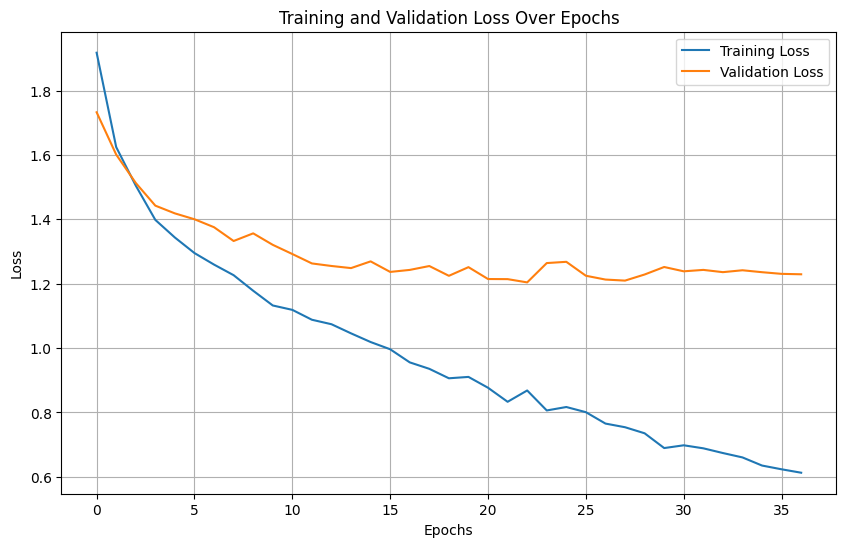

In [16]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(train_losses, val_losses)